In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats
from sklearn import linear_model
from sklearn.feature_selection import f_regression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [26]:
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4)

In [27]:
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861.0,0.0,0.0,NaN,0.0,0.0,0.0,12.0,2.0,10.0,0.0,0.0
1,Addison Town and Village,2577.0,3.0,0.0,NaN,0.0,0.0,3.0,24.0,3.0,20.0,1.0,0.0
2,Akron Village,2846.0,3.0,0.0,NaN,0.0,0.0,3.0,16.0,1.0,15.0,0.0,0.0
3,Albany,97956.0,791.0,8.0,NaN,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0,NaN
4,Albion Village,6388.0,23.0,0.0,NaN,3.0,4.0,16.0,223.0,53.0,165.0,5.0,NaN


## Preparing data set

Preparing a data set to use with linear regression(multivariable), we're using these variables: Population, Murder, robbery, and Property crime. We will use these to predict our target variable, property crime. 

In [28]:
#removing first rape column every entry was NAN
df = df.drop('Rape\n(revised\ndefinition)1', axis=1)

#removing last three rows, NAN values
df = df.drop([348,349,350])

#renaming columns
df.columns = ['City', 'Population', 'Violent', 'Murder', 'Rape', 'Robbery', 'Aggravated assault',
              'Property crime', 'Burglary','Larceny theft', 'Motor vehicle theft', 'Arson']

#Arson had 161 null values replacing with zero
df['Arson'].fillna(0, inplace=True)

In [29]:
df[df['Population'] > (df['Population'].quantile(.95))].index

Int64Index([  3,   7,  35,  53,  57,  62, 126, 206, 214, 216, 267, 272, 285,
            310, 314, 321, 340, 346],
           dtype='int64')

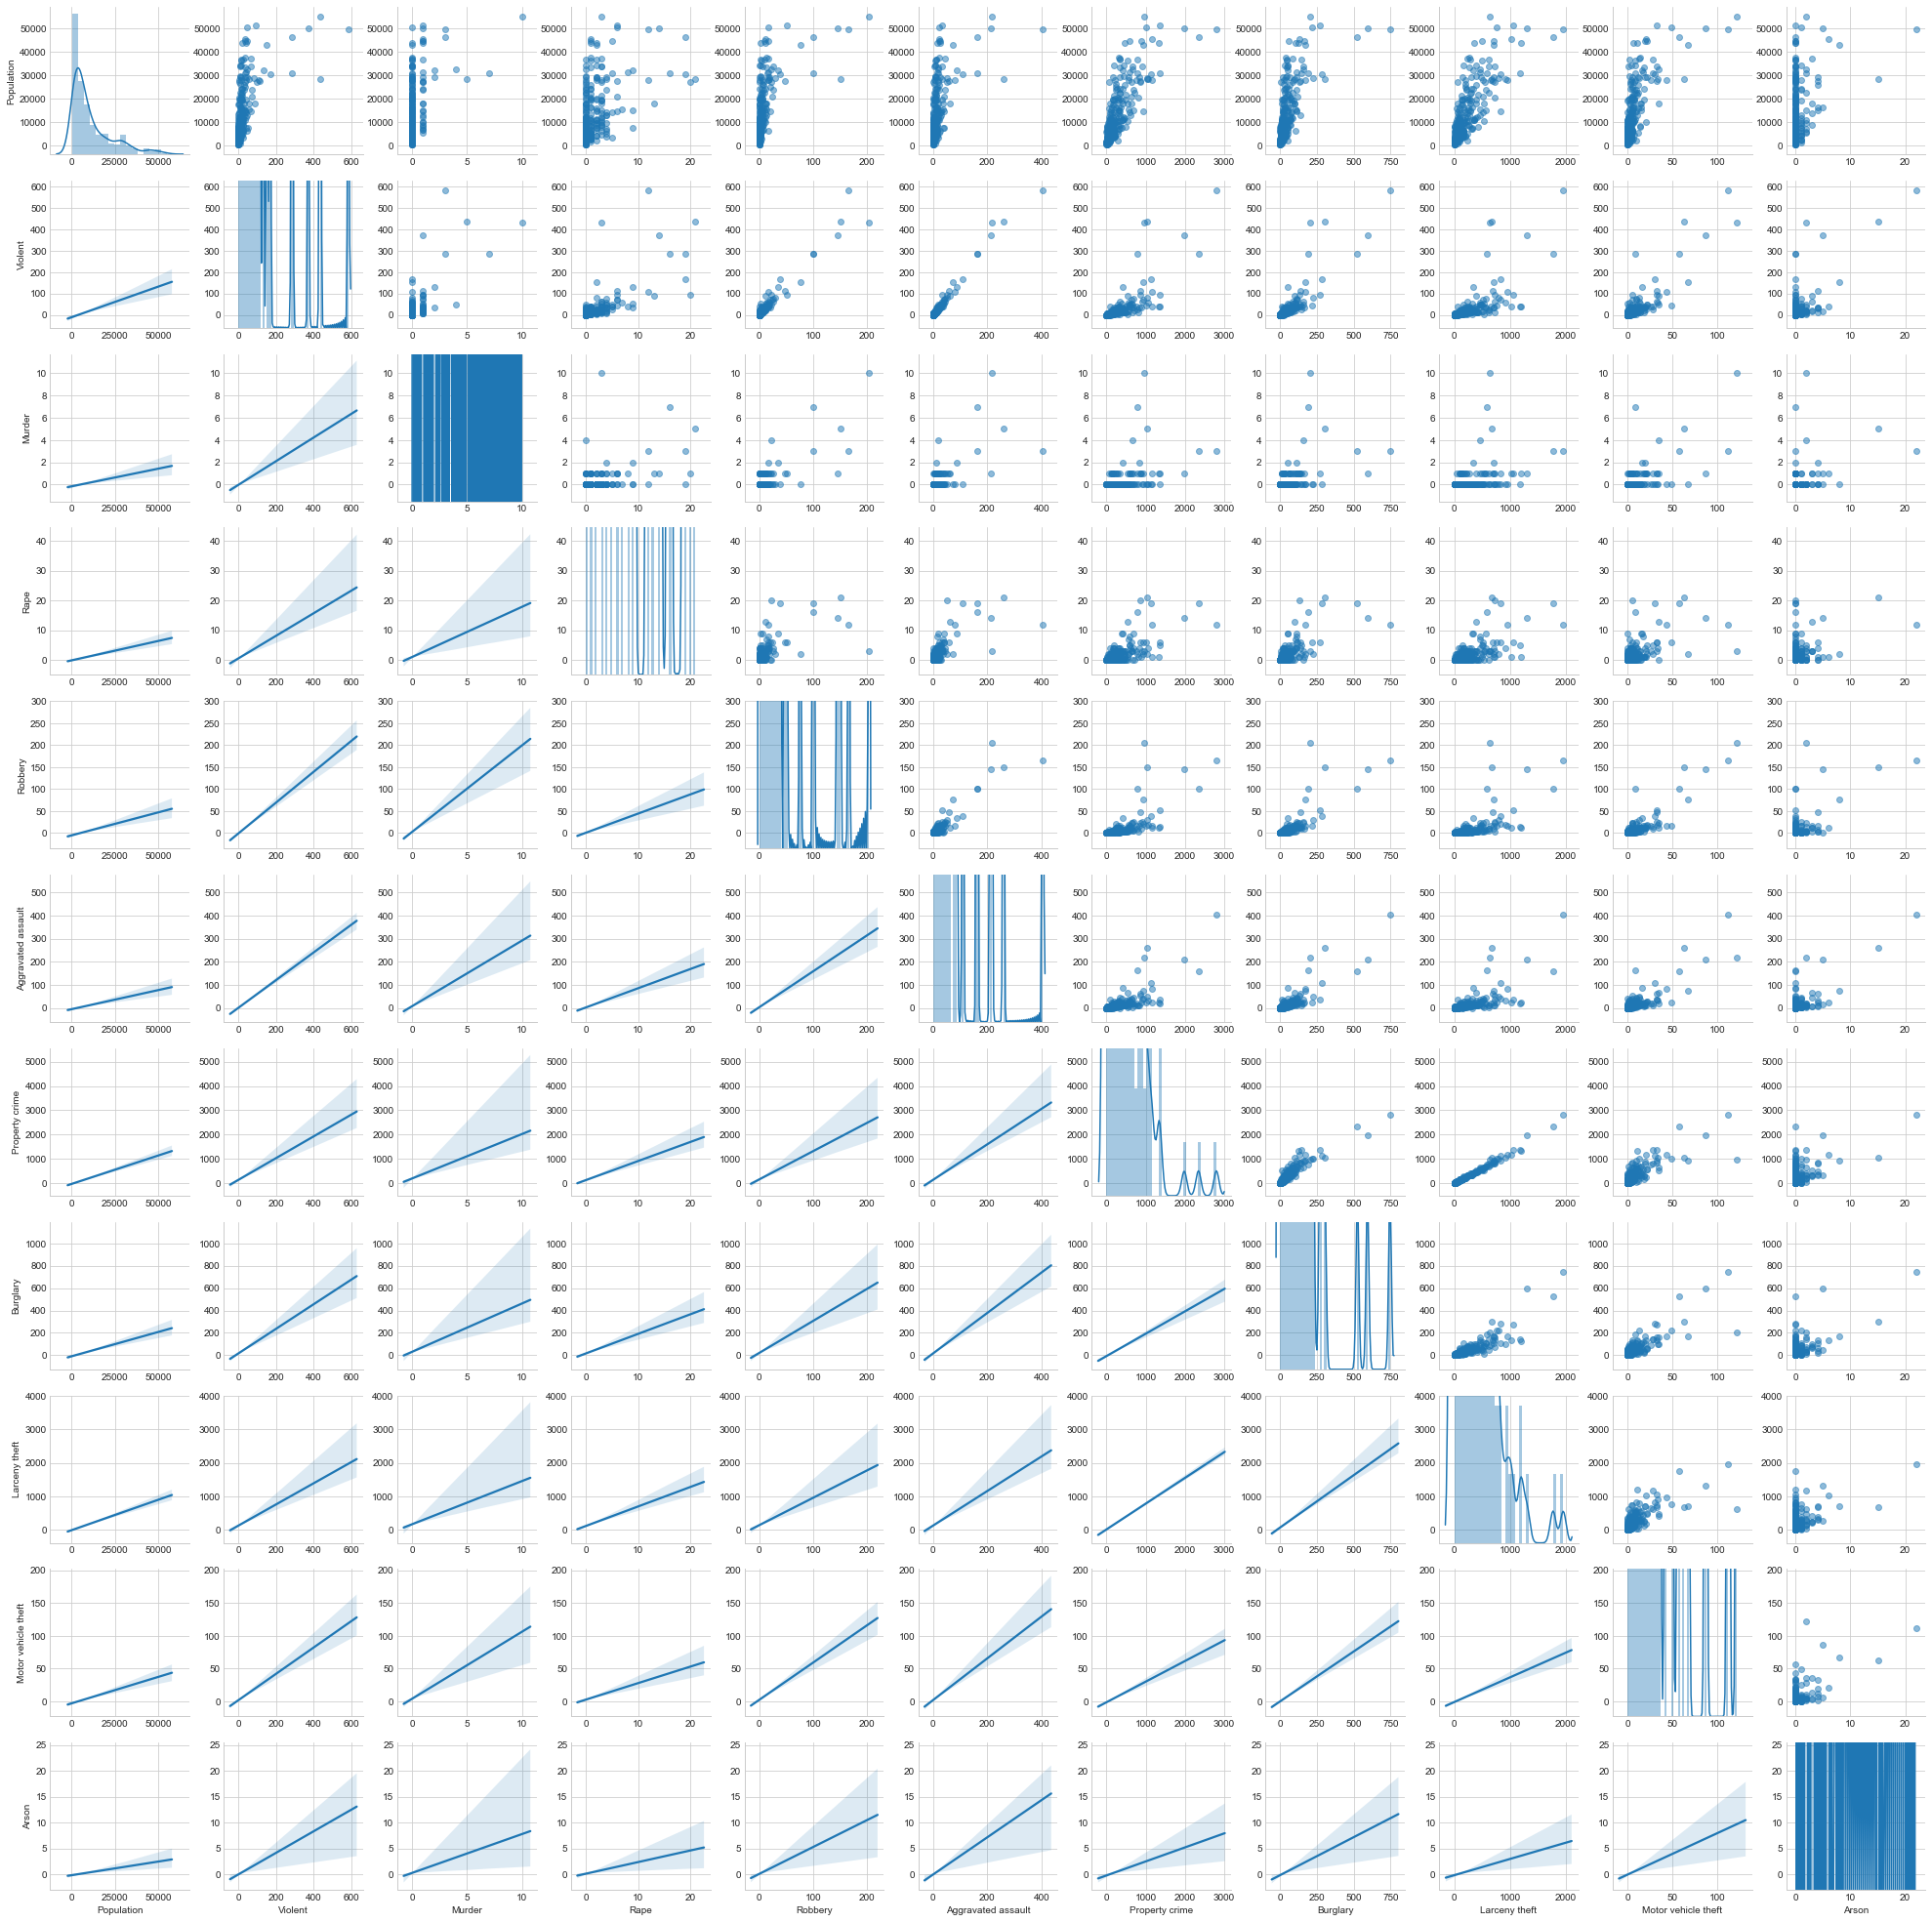

In [30]:
#droping outliers, where population > 95%
df = df.drop(df[df['Population'] > (df['Population'].quantile(.95))].index)

#Plotting scatter plot matrix
g = sns.PairGrid(df)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.distplot)
plt.show()

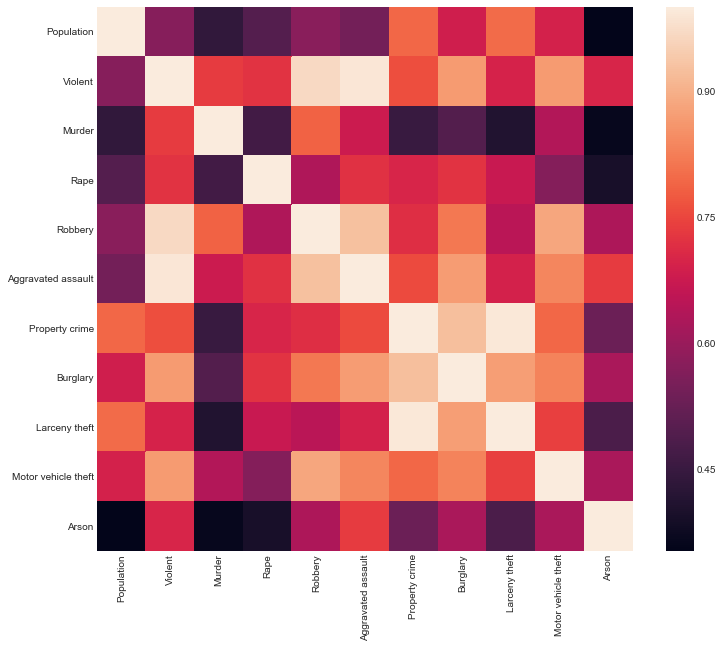

In [31]:
plt.subplots(figsize=(12,10)) 
sns.heatmap(df.corr())
plt.show()

## Feature engineering

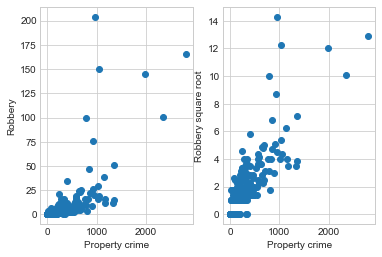

In [32]:
plt.subplot(1,2,1)
plt.scatter(df['Property crime'], df['Robbery'])
plt.xlabel('Property crime')
plt.ylabel('Robbery')
plt.subplot(1,2,2)
plt.scatter(df['Property crime'], np.sqrt(df['Robbery']))
plt.xlabel('Property crime')
plt.ylabel('Robbery square root')
plt.show()

In [33]:
#Doing a squareroot transform on robbery
df['Robbery_Sqrt'] = np.sqrt(df['Robbery'])

In [34]:
#Principle Component analysis
#choosing independent variables to use for PCA
pca_df = df[['Population', 'Burglary', 'Larceny theft']]

#['Population', 'Violent', 'Murder', 'Rape', 'Robbery', 'Aggravated assault', 'Burglary','Larceny theft', 'Motor vehicle theft']

#Standardizing variables
scaler = StandardScaler().fit(pca_df)
pca_df = scaler.transform(pca_df)

#Fitting PCA and seeing how much variance is explained by each component
pca = PCA()
pca.fit(pca_df)
pca.explained_variance_ratio_

array([ 0.85772485,  0.10768172,  0.03459343])

In [35]:
#Keeping first component
pca = pca.set_params(n_components=1)
pca_component = pca.fit_transform(pca_df)
df['PCA_component_one'] = pca_component

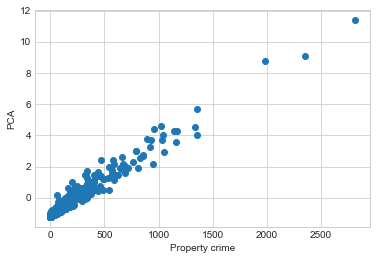

In [36]:
#Verifying linear relationship between target variable and independent variables(PCA)
plt.scatter(df['Property crime'], df['PCA_component_one'])
plt.xlabel('Property crime')
plt.ylabel('PCA')
plt.show()

## Modeling

Setting up multivariable linear regression model.

In [49]:
regr.fit(X, Y)

for train, test in kf.split(X, Y):
    data_train, data_test = X.iloc[train], X.iloc[test]
    target_train, target_test = Y.iloc[train], Y.iloc[test]
    regr.fit(data_train, target_train)
    prediction.extend(regr.predict(data_test))
    print('Rsquared:',regr.score(X, Y))
    


Rsquared: 0.979116925587
Rsquared: 0.979110002199
Rsquared: 0.963782662521
Rsquared: 0.976066167374
Rsquared: 0.979114396727


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
#Fitting model using whole data set. To latter validate this model on another data set.
regr.fit(X, Y)

# Calculating F-test and P-values for each feature.
f_test, p_values = f_regression(X, Y)

i = 0
for name in X.columns:
    print(name)
    print('f_test:  {}'.format(f_test[i]))
    print('p_value: {}\n'.format(p_values[i]))
    i += 1

PCA_component_one
f_test:  7254.626447148452
p_value: 9.249129516679568e-226



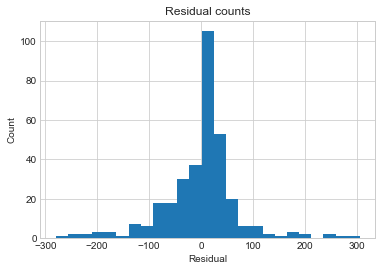

In [39]:
predicted = prediction
actual = df['Property crime']

# Calculate the residual/error.
residual = actual - predicted

plt.hist(residual, bins=25)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

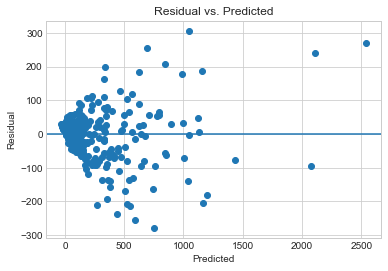

In [40]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [48]:
# Importing new data set(california crime) to test model on new data
cali_df = pd.read_excel('table_8_offenses_known_to_law_enforcement_california_by_city_2013.xls', header=4)

#Cleaning data set for modeling

#removing Nan column
cali_df = cali_df.drop('Rape\n(revised\ndefinition)1', axis=1)

#renaming columns
cali_df.columns = ['City', 'Population', 'Violent', 'Murder', 'Rape', 'Robbery', 'Aggravated assault',
              'Property crime', 'Burglary','Larceny theft', 'Motor vehicle theft', 'Arson']

#droping outliers, where population > 95%
#cali_df = cali_df.drop(df[df['Population'] > (df['Population'].quantile(.95))].index)

#Droping Nan rows
cali_df = cali_df.drop([462, 463])

#PCA
pca_df = cali_df[['Population', 'Burglary', 'Larceny theft']]

#using our scaler transform
pca_df = scaler.transform(pca_df)

#
pca_component = pca.transform(pca_df)
cali_df['PCA_component_one'] = pca_component


In [42]:
#executing model
Y = cali_df['Property crime']
X = cali_df[['PCA_component_one']]

cali_df['Predicted'] = regr.predict(X)
print('Rsquared:',regr.score(X, Y))

Rsquared: 0.978781157089


In [43]:
# Calculating F-test and P-values for each feature against the target variable.
f_test, p_values = f_regression(X, Y)

i = 0
for name in X.columns:
    print(name)
    print('f_test:  {}'.format(f_test[i]))
    print('p_value: {}\n'.format(p_values[i]))
    i += 1

PCA_component_one
f_test:  21569.993912404603
p_value: 0.0



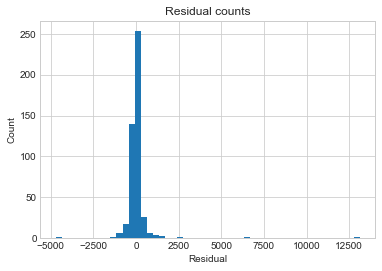

In [44]:
actual = cali_df['Property crime']
predicted = cali_df['Predicted']
# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual, bins=50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

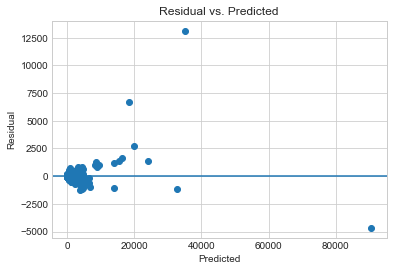

In [45]:
plt.scatter(cali_df['Predicted'], residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

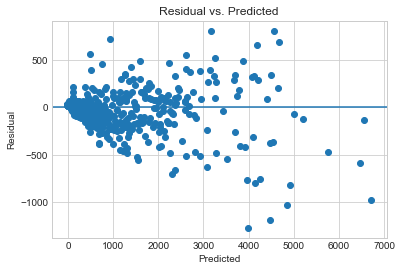

In [46]:
#Looking at a close up of the same graph by removing outliers
new_df = cali_df[cali_df['Predicted'] < 7000]
new_residual = new_df['Property crime'] - new_df['Predicted']


plt.scatter(new_df['Predicted'], new_residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [47]:
## Looking at errors larger then 5000
cali_df['Residual'] = residual
cali_df[cali_df['Residual'] > 5000]

,City,Population,Violent,Murder,Rape,Robbery,Aggravated assault,Property crime,Burglary,Larceny theft,Motor vehicle theft,Arson,PCA_component_one,Predicted,Residual
282,Oakland,403887.0,7984.0,90.0,180.0,4922.0,2792.0,25176.0,5058.0,13285.0,6833.0,140.0,88.098001,18499.815690,6676.184310
356,San Francisco,833863.0,7064.0,48.0,161.0,4202.0,2653.0,48324.0,5931.0,36527.0,5866.0,227.0,168.602767,35192.685044,13131.314956
